In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
from linear_operator.utils.cholesky import psd_safe_cholesky
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float64
device ='cpu'

### 1. Introduction

---

In this notebook we explore an approximate Gaussian process method *Sparse Variational Guassian process* We apply this method to the same toy example from previous examples 

*As always when reading this notebook it is recommended to collapse all code cells and explore as needed.*

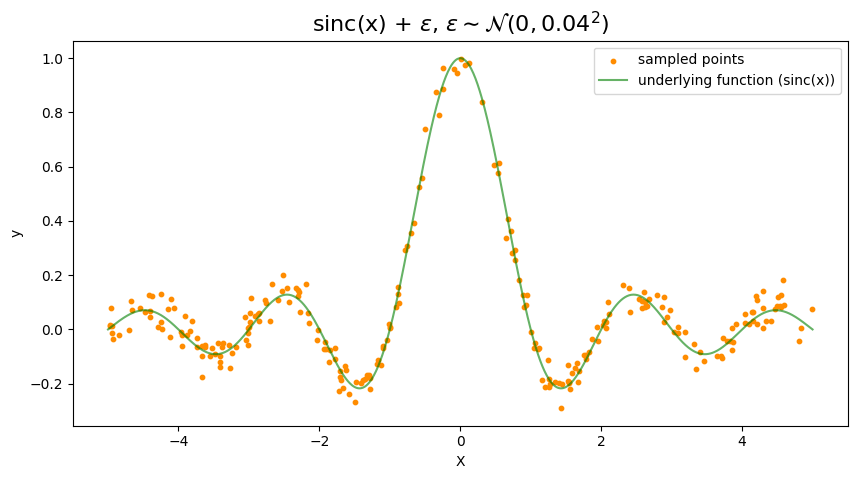

In [20]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 250

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


### Sparse Variational Gaussian Process
---

A Sparse Variational Gaussian Process (SVGP) is an approximate gaussian process method that like Nystrom Kernel Ridge Regression attempts to approxiate the full $n \times n$ Kernel matrix using a set of $m$ inducing points. In the SVGP setting inducing points are generally free to move throughout the ambient data space and are variationally optimized to minimize an objective function defined below.

Let $m \in \mathbb{N}$ be fixed, and $\Gamma$ be a set of variational parameters defined by
$$
\begin{aligned}
\Gamma:=\{\nu:=(Z, \mu, \Sigma) \mid & Z:=\left(z_1, \ldots, z_m\right) \in \mathcal{X}^m, k_{Z Z} \text { is invertible, } \\
& \left.\mu \in \mathbb{R}^m, \Sigma \in \mathbb{R}_{\succ 0}^{m \times m}\right\}
\end{aligned}
$$
where $\mathbb{R}_{\succ 0}^{m \times m}$ stands for symmetric and positive definite matrices in $\mathbb{R}^{m \times m}$. The points $Z=\left(z_1, \ldots, z_m\right)$ are the so-called inducing inputs, based on which we approximate the posterior GP. On the other hand, $\mu$ and $\Sigma$ are parameters for the distribution of function.
We then define a variational family $\mathcal{Q}_{\Gamma}:=\left\{\mathbb{Q}^\nu \mid \nu \in \Gamma\right\}$ as a set of Gaussian processes parametrized by the triplet ${ }^2 \nu=(Z, \mu, \Sigma)$ defined as follows:
$$
\begin{aligned}
\mathbb{Q}^\nu & :=G P\left(m^\nu, k^\nu\right), \\
m^\nu(x) & :=k_Z(x)^{\top} k_{Z Z}^{-1} \mu, \\
k^\nu\left(x, x^{\prime}\right) & :=k\left(x, x^{\prime}\right)-k_Z(x)^{\top} k_{Z Z}^{-1} k_Z\left(x^{\prime}\right)+k_Z(x)^{\top} k_{Z Z}^{-1} \Sigma k_{Z Z}^{-1} k_Z\left(x^{\prime}\right) .
\end{aligned}
$$

**The aim of variational inference is to obtain a distribution $\mathbb{Q}^{\nu^*}$ from the variational family $\mathcal{Q}_{\Gamma}$ that best approximates the posterior measure $\mathbb{P}^{F \mid y}$ in terms of the Kullback-Leibler (KL) divergence, without explicitly computing the posterior. That is, we want to compute $\nu^* \in \Gamma$ such that**
$$
\nu^* \in \arg \min _{\nu \in \Gamma} K L\left(\mathbb{Q}^\nu \| \mathbb{P}^{F \mid y}\right) .
$$

Equivilantly 
$$K L\left(\mathbb{Q}^\nu \| \mathbb{P}^{F \mid y}\right)=\log p(y)-\mathcal{L}(\nu) $$

where $p(y)$ is the marginal likelihood, or the Evidence, of observing $y=\left(y_1, \ldots, y_n\right)^{\top}$ under the prior $F \sim G P(m, k)$ and the observation model $y_i \sim \mathcal{N}\left(F\left(x_i\right), \sigma^2\right)$, while $\mathcal{L}(\nu)$ is the Evidence Lower Bound (ELBO) defined as
$$
\mathcal{L}(\nu):=-K L\left(\mathbb{Q}_Z^\nu \| \mathbb{P}_Z\right)+\mathbb{E}_{F^\nu \sim \mathbb{Q}^\nu}\left[\log p\left(y \mid F_X^\nu\right)\right]
$$
Note that we also have 
$$
\begin{aligned}
& K L\left(\mathbb{Q}_Z^\nu \| \mathbb{P}_Z\right)=\int_{\mathbb{R}^m} \log \left(\frac{d \mathbb{Q}_Z^\nu}{d \mathbb{P}_Z}\left(f_Z\right)\right) d \mathbb{Q}_Z^\nu\left(f_Z\right) \\
& =\frac{1}{2}\left(\operatorname{tr}\left(k_{Z Z}^{-1} \Sigma\right)+\mu^{\top} k_{Z Z}^{-1} \mu-m+\log \left(\frac{\operatorname{det}\left(k_{Z Z}\right)}{\operatorname{det}(\Sigma)}\right)\right)
\end{aligned}
$$

and 
$$
\mathbb{E}_{F^\nu \sim \mathbb{Q}^\nu}\left[\log p\left(y \mid F_X^\nu\right)\right]=-n \log \left(\sqrt{2 \pi \sigma^2}\right)-\mathbb{E}_{F^\nu \sim \mathbb{Q}^\nu}\left[\sum_{i=1}^n \frac{\left(y_i-F^\nu\left(x_i\right)\right)^2}{2 \sigma^2}\right]
$$

Since the marginal likelihood $p(y)$ under the original GP prior does not depend on the variational parameters $\nu$, the minimization of the KL divergence  is equivalent to the maximization of the ELBO $\mathcal{L}(\nu)$. Titsias (2009a, Eq.(10)) show that$ for fixed inducing points $Z$, the optimal parameters $\mu^*$ and $\Sigma^*$ that maximize the ELBO are given analytically as
$$
\begin{gathered}
\mu^*:=k_{Z Z}\left(\sigma^2 k_{Z Z}+k_{Z X} k_{X Z}\right)^{-1} k_{Z X} y \\
\Sigma^*:=k_{Z Z}\left(k_{Z Z}+\sigma^{-2} k_{Z X} k_{X Z}\right)^{-1} k_{Z Z}
\end{gathered}
$$
and the resulting ELBO, denoted by $\mathcal{L}^*$, is
$$
\begin{aligned}
\mathcal{L}^*= & -\frac{1}{2} \log \operatorname{det}\left(q_{X X}+\sigma^2 I_n\right)-\frac{1}{2} y^{\top}\left(q_{X X}+\sigma^2 I\right)^{-1} y \\
& -\frac{n}{2} \log 2 \pi-\frac{1}{2 \sigma^2} \operatorname{tr}\left(k_{X X}-q_{X X}\right)
\end{aligned}
$$
where $q$ is the approximate kernel defined below. Inserting these expressions in the definition of the variational distribution , the optimal variational approximation (for fixed inducingpoints $Z$ is given by $G P\left(m^*, k^*\right)$ with 
$$
\begin{aligned}
m^*(x) & :=k_Z(x)^{\top}\left(\sigma^2 k_{Z Z}+k_{Z X} k_{X Z}\right)^{-1} k_{Z X} y \\
k^*\left(x, x^{\prime}\right) & :=k\left(x, x^{\prime}\right)-k_Z(x)^{\top} k_{Z Z}^{-1} k_Z\left(x^{\prime}\right) \\
& +k_Z(x)^{\top}\left(k_{Z Z}+\sigma^{-2} k_{Z X} k_{X Z}\right)^{-1} k_Z\left(x^{\prime}\right) .
\end{aligned}
$$

$$
\begin{aligned}
q\left(x, x^{\prime}\right) & :=\left\langle P_M(k(\cdot, x)), P_M\left(k\left(\cdot, x^{\prime}\right)\right)\right\rangle_{\mathcal{H}_k} \\
& =\left\langle k_Z(x)^{\top} k_{Z Z}^{-1} k_Z(\cdot), k_Z\left(x^{\prime}\right)^{\top} k_{Z Z}^{-1} k_Z(\cdot)\right\rangle_{\mathcal{H}_k} \\
& =k_Z(x)^{\top} k_{Z Z}^{-1} k_Z\left(x^{\prime}\right), \quad x, x^{\prime} \in \mathcal{X},
\end{aligned}
$$

In [21]:
sigma=.05
num_inducing_points = int(train_data.shape[0] * .1)
print("total inducing points : ",num_inducing_points)
lengthscale = 0.1 

total inducing points :  25


C:\Users\chris\AppData\Local\Temp\ipykernel_29244\1327602062.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points_tensor = torch.tensor(inducing_points, dtype=global_dtype).clone().detach()
C:\Users\chris\AppData\Local\Temp\ipykernel_29244\1327602062.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_data, dtype=global_dtype).clone().detach()
C:\Users\chris\AppData\Local\Temp\ipykernel_29244\1327602062.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.

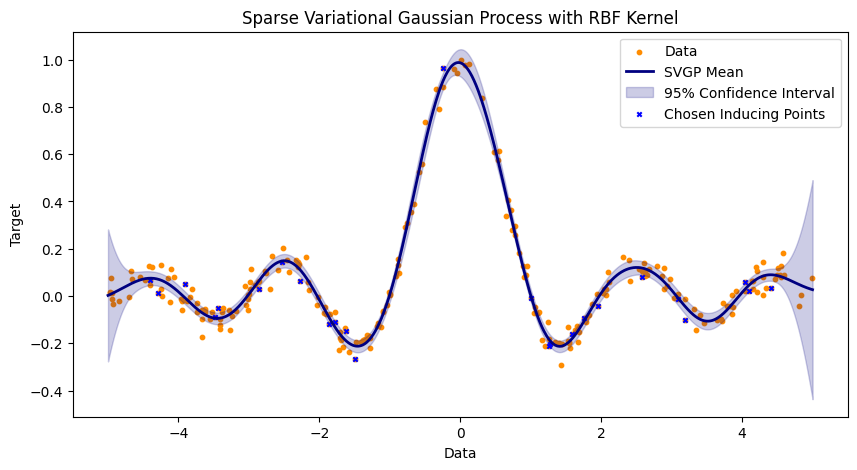

In [32]:
class SparseVariationalGaussianProcess:
    def __init__(self, inducing_points, lengthscale=1.0, sigma=0.1, kernel=None, dtype=global_dtype):
        self.inducing_points = inducing_points.clone().detach().to(dtype=dtype)
        self.sigma = sigma
        self.kernel = kernel(nu=1.5,lengthscale=lengthscale)
        self.dtype = dtype

        if self.dtype==torch.float32:
            self.jitter = 1e-2
        else: 
            self.jitter = 1e-16

    def fit(self, X, y):
        self.y_train = y.to(dtype=self.dtype)
        self.K_zz = self.kernel(self.inducing_points, self.inducing_points).to(dtype=self.dtype).to_dense() + self.jitter * torch.eye(len(self.inducing_points), dtype=self.dtype)
        self.K_zx = self.kernel(self.inducing_points, X).to(dtype=self.dtype).to_dense()
        
        self.L_zz = psd_safe_cholesky(self.K_zz)
        self.K_zz_inv = torch.cholesky_inverse(self.L_zz)
        

    def predict(self, test_x):
        test_x = test_x.to(dtype=self.dtype)
        K_Z = self.kernel(self.inducing_points, test_x).to(dtype=self.dtype).to_dense()
        
        L = psd_safe_cholesky(self.sigma**2 * self.K_zz + self.K_zx @ self.K_zx.T)
        L_inv = torch.cholesky_inverse(L)
        
        mean_star = K_Z.T @ L_inv @ self.K_zx @ self.y_train
        
        term1 = self.kernel(test_x, test_x).to(dtype=self.dtype)
        term2 = -K_Z.T @ self.K_zz_inv @ K_Z
        
        L_full = psd_safe_cholesky(self.K_zz + (1 / self.sigma**2) * self.K_zx @ self.K_zx.T)
        L_full_inv = torch.cholesky_inverse(L_full)
        
        term3 = K_Z.T @ L_full_inv @ K_Z
        
        cov_star = term1 + term2 + term3
        
        return mean_star.squeeze(), cov_star



# Select inducing points from the training data
inducing_indices = np.random.choice(train_data.shape[0], num_inducing_points, replace=False)
inducing_points = train_data[inducing_indices]  # Choose points from training data
inducing_points_tensor = torch.tensor(inducing_points, dtype=global_dtype).clone().detach()

# Initialize and fit the SVGP model
svgp = SparseVariationalGaussianProcess(inducing_points_tensor, lengthscale=lengthscale, sigma=sigma, kernel=RBFKernel)
train_data_tensor = torch.tensor(train_data, dtype=global_dtype).clone().detach()
train_labels_tensor = torch.tensor(train_labels, dtype=global_dtype).clone().detach()
svgp.fit(train_data_tensor, train_labels_tensor)

# Predict on test data
test_data_tensor = torch.tensor(test_data, dtype=global_dtype).clone().detach()
mean_torch, covariance_torch = svgp.predict(test_data_tensor)
SVGP_mean = mean_torch.detach().numpy()
SVG_covariance = covariance_torch.detach().numpy()
std = np.sqrt(np.diag(SVG_covariance))

# Retrieve the labels for the inducing points from the training labels
inducing_labels = train_labels_tensor[inducing_indices].numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(train_data, train_labels, s=10, color='darkorange', label='Data')
plt.plot(test_data, SVGP_mean, color='navy', lw=2, label='SVGP Mean')
plt.fill_between(test_data.ravel(), SVGP_mean - 1.96 * std, SVGP_mean + 1.96 * std, color='navy', alpha=0.2, label='95% Confidence Interval')

# Plot inducing points with their labels
plt.scatter(inducing_points, inducing_labels, color='blue', s=10, label='Chosen Inducing Points', marker='x')

plt.xlabel('Data')
plt.ylabel('Target')
plt.title('Sparse Variational Gaussian Process with RBF Kernel')
plt.legend()
plt.show()


### Time Complexity 

To evaluate the time complexity of the Sparse Variational Gaussian Process (SVGP), we'll analyze the operational costs of its key phases: fitting and prediction. We use $n$ for the number of training points, $m$ for the number of inducing points, and $Y$ for the number of test points. Typically, $m \ll n$ and $Y < n$.

---

### Time Complexity of Sparse Variational Gaussian Process (SVGP)
<center>

| **Step**       | **Operation**                                          | **Complexity**          |
|-----------------|--------------------------------------------------------|-------------------------|
| **Fitting**     | Kernel Computation (Inducing and Training Points)    | $ \mathcal{O}(nm^2) $    |
|                 | Cholesky Decomposition of $ K_{zz} $                  | $ \mathcal{O}(m^3) $     |
|                 | Cholesky Solve (for $ K_{zz}^{-1} $)                  | $ \mathcal{O}(m^3) $     |
| **Inference**   | Kernel Computation (Inducing Points and Test Points) | $ \mathcal{O}(Ym) $     |
|                 | Solving Linear Systems (Cholesky Decomposition of $ \sigma^2 K_{zz} + K_{zx} K_{zx}^T $) | $ \mathcal{O}(m^3) $     |
|                 | Computation of Covariance Matrix                      | $ \mathcal{O}(Ym^2) $   |

</center>

**Summary**:  
- **Fitting**: Dominated by $\mathcal{O}(m^3)$ due to matrix inversion and $\mathcal{O}(nm^2)$ for kernel computations.  
- **Inference**: $\mathcal{O}(Ym^2)$ for kernel computation and $\mathcal{O}(Ym)$ for prediction computation.

#insert dialouge of other optimizations 
